<img src="http://landlab.github.io/assets/Landlab-logo.png"
style="float:left;width:150px;padding:0px"> 
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />

### Use Case 3 supplement: Downloading Gridded Hydrometeorology forcing for a Cellular Automaton Ecohydrologic Model

* Import a shapefile for New Mexico.
* Set three distinct elevation bands.
* Calculate mean climatology for each of the three elevation bands.
* Save mean characteristics for each elevation band in a separate JSON file.
<br />



**This research is actively being developed by the Watershed Dynamics Research Group in the Civil and Environmental Engineering Department at the University of Washington for the Thunder Creek basin in the Skagit Watershed, WA, USA in collaboration with the HydroShare team, CUAHSI and NCSA partners.**
 <br /> <img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:left;width:120px;padding:10px">   
<img src="http://www.ncsa.illinois.edu/assets/img/logos_ncsa.png"
 style="float:right;width:120px;padding:10px"> 
<img src="https://www.cuahsi.org/assets/images/logo.png">

## To run this notebook:

Click in or on each shaded code block below and use ***shift + enter*** or ***shift + return*** keys. Alternatively, you can run groups of cells by clicking ***Cell*** on the menu above and selecting among the various run options. This is also where you can clear outputs from previous runs.

If an error occurs, click on ***Kernel*** and then select ***Restart and Clear Outputs*** in the menu above. While exiting the notebook, click ***File*** and then select ***Close and Halt***.
<br />For more instructions on how to run an interactive IPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small><br>
<small>For tutorials on learning Landlab, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<br>
<small>For the unexpanded version to download and run, click here: <a href="http://nbviewer.jupyter.org/github/landlab/tutorials/blob/master/ecohydrology/cellular_automaton_vegetation_DEM/cellular_automaton_vegetation_DEM_unexpanded.ipynb">http://nbviewer.jupyter.org/github/landlab/tutorials/blob/master/ecohydrology/cellular_automaton_vegetation_DEM/cellular_automaton_vegetation_DEM_unexpanded.ipynb</a></small><br>

## 1.  Notebook Setup and Preparation

This notebook is a supplemental notebook for 'Use case 3 - Reuse_ecohydrology_gridhydromet.ipynb'. In this notebook, we will use ***ogh***, a conda package to download and process gridded hydro-meteorologic datasets, to download Livneh et al. 2015 dataset that has historical daily precipitation and temperature data for years 1950 through 2013.


**References**

Livneh B., T.J. Bohn, D.S. Pierce, F. Munoz-Ariola, B. Nijssen, R. Vose, D. Cayan, and L.D. Brekke, 2015: A spatially comprehensive, hydrometeorological data set for Mexico, the U.S., and southern Canada 1950-2013, Nature Scientific Data, 5:150042, doi:10.1038/sdata.2015.42.

Phuong, J., Bandaragoda C., Istanbulluoglu, E., Beveridge, C., Strauch, R., Setiawan, L., Mooney, S. D. (in-review). Automated retrieval, preprocessing, and visualization of gridded hydrometeorology data products for spatial-temporal exploratory analysis and intercomparison.

** 1.1.1  Import libraries installed on CUAHSI JupyterHub server **

To run this notebook, we must import several libraries.
The hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading. and creation. Additional libraries support the functions of Landlab.

In [1]:
#Python libraries available on CUAHSI JupyterHub 
import os, json
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import warnings 
warnings.filterwarnings('ignore')

# tools for downloading & processing gridded hydro-meteorology data
import ogh

#HydroShare Utilities
from utilities import hydroshare
hs=hydroshare.hydroshare()

Adding the following system variables:
   HS_USR_NAME = saisiddu
   HS_RES_ID = 70b977e22af544f8a7e5a803935c329c
   HS_RES_TYPE = genericresource
   JUPYTER_HUB_IP = jupyter.cuahsi.org

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => saisiddu
Successfully established a connection with HydroShare


**1.1.2 Where are we in Hydroshare space?**

In [3]:
homedir = ogh.mapContentFolder(str(os.environ["HS_RES_ID"]))
print('Data will be loaded from and save to:'+homedir)

Data will be loaded from and save to:/home/jovyan/work/notebooks/data/70b977e22af544f8a7e5a803935c329c/70b977e22af544f8a7e5a803935c329c/data/contents


## 2. Download and generate lists of gridded climate points for a watershed

For this use case, we will explore the influence of climatology of New Mexico on vegetation pattern evolution. We will specifically be looking at the change in climatology with respect to elevation. Therefore, we need to download data for the entire state of New Mexico, parse this data and group them based on the elevation ranges, and finally calculate mean characteristics for each group and store them in JSON files.

For this exercise, we will retrieve the shape file for New mexico from the resource in the following url: https://www.hydroshare.org/resource/5b401852758e4d49a87a788c1008b027/. The data for our processing routines can be retrieved using the *getResourceFromHydroShare* function by passing in the global identifier from the url above.  In the next cell, we will download this resource from HydroShare, and identify that the table in this resource is the 'mappingfile' variable identifying the Lat/Long points to be used for downloading hydrometeorology data.  The file must include columns with station numbers (this can be aribitrary), latitude, longitude, and elevation. The header of these columns must be FID, LAT, LONG_, and ELEV or RASTERVALU, respectively. The station numbers will be used for the remainder of the code to uniquely reference data from each climate station, as well as to identify minimum, maximum, and average elevation of all of the climate stations.

**2.1 Download areas of interest from HydroShare Resources**

In [4]:
# This resource type is Composite Resource containing a Geographic Feature (ESRI Shapefile). 
hs.getResourceFromHydroShare('5b401852758e4d49a87a788c1008b027')
download_extent_shapefile = hs.content['New_Mexico.shp']

This resource already exists in your userspace.
5b401852758e4d49a87a788c1008b027/
|-- 5b401852758e4d49a87a788c1008b027/
|   |-- bagit.txt
|   |-- manifest-md5.txt
|   |-- readme.txt
|   |-- tagmanifest-md5.txt
|   |-- data/
|   |   |-- resourcemap.xml
|   |   |-- resourcemetadata.xml
|   |   |-- contents/
|   |   |   |-- New_Mexico.cpg
|   |   |   |-- New_Mexico.shp
|   |   |   |-- NewMexicoEcohydrology.jpg
|   |   |   |-- New_Mexico.shx
|   |   |   |-- New_Mexico.dbf
|   |   |   |-- New_Mexico.prj
|   |   |   |-- New_Mexico.shp.xml

Do you want to overwrite these data [Y/n]? Y
Download Finished                               
Successfully downloaded resource 5b401852758e4d49a87a788c1008b027


In [5]:
### TreatGeoSelf to a mapping tool that uses your shapefile
# Reuse this exising point shapefile of available 1/16 degree grid centroid locations 
# for Conterminous United States (CONUS) shared on HydroShare as a public resource

hs.getResourceFromHydroShare('ef2d82bf960144b4bfb1bae6242bcc7f')
NAmer = hs.content['NAmer_dem_list.shp']

This resource already exists in your userspace.
ef2d82bf960144b4bfb1bae6242bcc7f/
|-- ef2d82bf960144b4bfb1bae6242bcc7f/
|   |-- bagit.txt
|   |-- manifest-md5.txt
|   |-- readme.txt
|   |-- tagmanifest-md5.txt
|   |-- data/
|   |   |-- resourcemap.xml
|   |   |-- resourcemetadata.xml
|   |   |-- contents/
|   |   |   |-- NAmer_dem_list.cpg
|   |   |   |-- NAmer_dem_list.dbf
|   |   |   |-- NAmer_dem_list.prj
|   |   |   |-- NAmer_dem_list.sbn
|   |   |   |-- NAmer_dem_list.sbx
|   |   |   |-- NAmer_dem_list.shp
|   |   |   |-- NAmer_dem_list.shx

Do you want to overwrite these data [Y/n]? Y
Download Finished                               
Successfully downloaded resource ef2d82bf960144b4bfb1bae6242bcc7f


**2.2.1 Read in the Observatory metadata file**

This file contains the variables, data types and metadata related to Livneh et al., 2013; 2015 and Salathe et al., 2014 gridded hydrometeorology products. 

In [6]:
#Assuming this is pulled from Github, how can we import this from Utilities.
#Otherwise it needs to be in each HydroShare resource - which if fine too. 
# initialize ogh_meta data file
meta_file = dict(ogh.ogh_meta())
sorted(meta_file.keys())

['dailymet_bclivneh2013',
 'dailymet_livneh2013',
 'dailymet_livneh2015',
 'dailyvic_livneh2013',
 'dailyvic_livneh2015',
 'dailywrf_bcsalathe2014',
 'dailywrf_salathe2014']

**2.2.2 TreatGeoSelf() to a easily generated list of lat/long points in your area of interest**

In [7]:
%%time
#New Mexico Extent is approximately 7900 gridded cells
mappingfile = ogh.treatgeoself(shapefile=download_extent_shapefile, 
                               NAmer=NAmer, 
                               buffer_distance=0,
                               mappingfile=os.path.join(homedir,'new_mexico_gridmet.csv'))
print(mappingfile)

(7917, 4)
   FID       LAT      LONG_    ELEV
0    0  36.96875 -103.03125  1431.0
1    1  36.96875 -103.09375  1462.0
2    2  36.96875 -103.15625  1437.0
3    3  36.96875 -103.21875  1451.0
4    4  36.96875 -103.28125  1478.0
/home/jovyan/work/notebooks/data/70b977e22af544f8a7e5a803935c329c/70b977e22af544f8a7e5a803935c329c/data/contents/new_mexico_gridmet.csv
CPU times: user 23.4 s, sys: 527 ms, total: 24 s
Wall time: 24 s


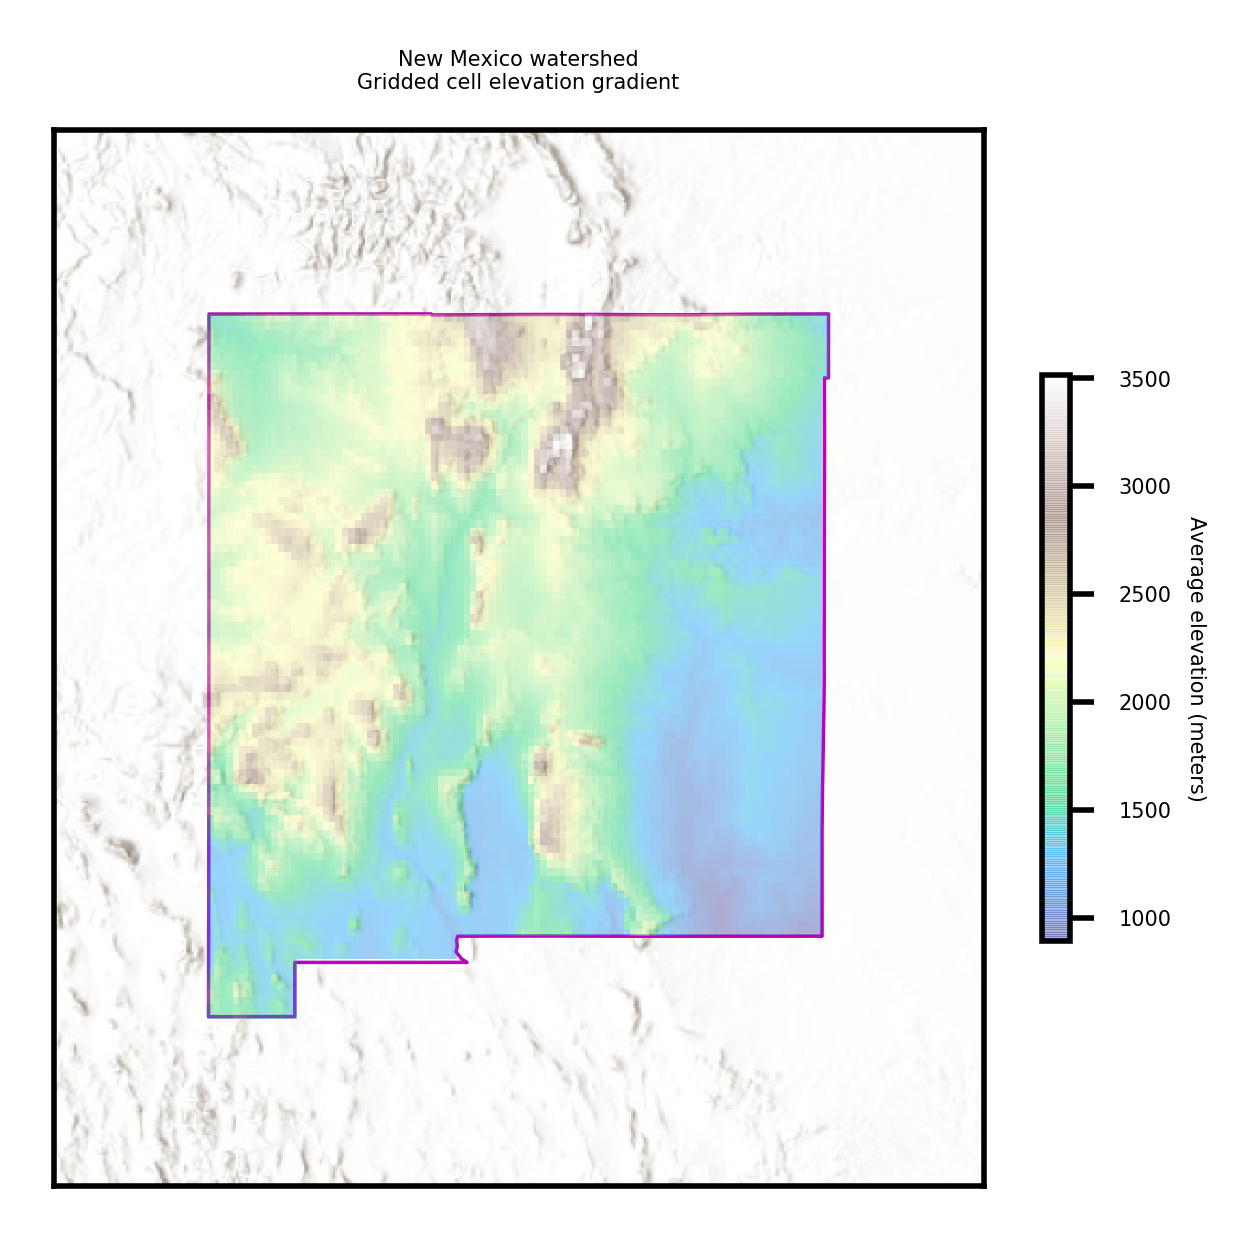

In [8]:
ogh.griddedCellGradient(mappingfile=mappingfile, 
                        shapefile=download_extent_shapefile,
                        outfilepath=os.path.join(homedir, 'NM_elev_gradient.png'),
                        plottitle='New Mexico watershed\nGridded cell elevation gradient',
                        colorbar_label='Average elevation (meters)',
                        spatial_resolution=1/16, margin=0.25, epsg=3857, column='ELEV',
                        basemap_image='Elevation/World_Hillshade', cmap='terrain')

 ## 3. Download gridded climate data 
 
 
 **3.1 Get Daily Meteorologic Data from  Livneh et al. 2015 (1950-2013; North America extent)**


In [9]:
# %%time
# # uncomment and run if the files have already been downloaded
# ogh.remapCatalog(homedir=homedir, 
#                  mappingfile=mappingfile, 
#                  subdir='livneh2015/Daily_MET_1950_2013/raw', 
#                  catalog_label='dailymet_livneh2015')

In [10]:
%%time
# From the reference mapping file, read-in, download, and unzip the data files for the longitude and latitude points
ogh.getDailyMET_livneh2015(homedir, mappingfile)

Meteorology_Livneh_NAmerExt_15Oct2014_36.46875_-104.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.21875_-104.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.71875_-103.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.96875_-103.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.96875_-105.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.21875_-104.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.46875_-104.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.96875_-103.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.96875_-105.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.71875_-103.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.46875_-104.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.21875_-104.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.96875_-103.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.96875_-105.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.71875_-103.65625 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_36.71875_-105.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.46875_-105.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.96875_-104.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.96875_-107.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.21875_-106.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.71875_-105.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.46875_-105.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.96875_-104.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.96875_-107.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.21875_-106.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.71875_-105.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.46875_-105.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.96875_-104.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.96875_-107.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.71875_-105.21875 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_36.96875_-106.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.46875_-107.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.71875_-106.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.21875_-107.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.96875_-108.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.96875_-106.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.46875_-107.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.71875_-106.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.21875_-107.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.96875_-108.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.96875_-106.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.46875_-107.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.71875_-106.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.21875_-108.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.96875_-108.84375 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_36.71875_-108.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.90625_-104.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.96875_-107.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.46875_-108.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.15625_-103.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.71875_-108.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.90625_-104.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.96875_-107.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.46875_-108.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.15625_-103.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.71875_-108.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.90625_-104.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.46875_-108.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.96875_-107.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.15625_-103.59375 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_36.90625_-103.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.90625_-105.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.65625_-103.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.40625_-104.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.15625_-105.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.90625_-103.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.90625_-105.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.65625_-103.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.40625_-104.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.15625_-105.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.90625_-103.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.90625_-105.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.65625_-103.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.40625_-104.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.15625_-105.15625 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_36.90625_-104.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.15625_-106.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.90625_-107.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.65625_-105.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.40625_-105.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.90625_-104.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.15625_-106.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.90625_-107.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.65625_-105.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.40625_-105.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.90625_-104.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.15625_-106.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.65625_-105.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.40625_-105.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.90625_-107.46875 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_36.40625_-107.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.65625_-106.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.90625_-106.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.90625_-108.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.15625_-108.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.40625_-107.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.65625_-106.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.90625_-106.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.15625_-108.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.90625_-108.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.40625_-107.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.65625_-106.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.90625_-106.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.15625_-108.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.90625_-109.03125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_36.65625_-108.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.84375_-104.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.40625_-108.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.09375_-103.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.90625_-107.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.65625_-108.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.84375_-104.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.40625_-108.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.09375_-103.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.65625_-108.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.90625_-107.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.84375_-104.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.40625_-108.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.09375_-103.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.90625_-107.84375 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_36.34375_-104.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.09375_-105.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.84375_-103.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.59375_-103.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.84375_-105.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.34375_-104.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.09375_-105.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.84375_-103.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.59375_-103.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.84375_-106.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.34375_-104.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.09375_-105.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.84375_-103.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.59375_-103.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.84375_-106.09375 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_35.84375_-107.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.59375_-105.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.09375_-106.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.34375_-105.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.84375_-104.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.84375_-107.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.59375_-105.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.34375_-105.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.09375_-106.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.84375_-104.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.84375_-107.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.84375_-104.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.59375_-105.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.34375_-106.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.09375_-106.78125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_36.59375_-106.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.84375_-106.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.84375_-109.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.34375_-107.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.09375_-108.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.84375_-106.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.59375_-106.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.78125_-103.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.09375_-108.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.59375_-106.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.34375_-107.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.84375_-106.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.78125_-103.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.59375_-106.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.09375_-108.34375 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_36.59375_-108.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.03125_-103.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.34375_-108.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.84375_-107.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.78125_-104.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.59375_-108.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.03125_-103.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.34375_-109.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.84375_-107.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.78125_-104.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.59375_-108.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.03125_-103.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.84375_-107.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.28125_-103.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.78125_-104.71875 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_36.53125_-103.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.78125_-103.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.03125_-105.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.78125_-106.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.28125_-104.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.53125_-103.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.78125_-103.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.03125_-105.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.78125_-106.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.28125_-104.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.53125_-103.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.78125_-103.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.78125_-106.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.03125_-105.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.28125_-104.65625 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_35.78125_-107.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.28125_-106.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.53125_-105.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.03125_-106.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.78125_-104.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.78125_-107.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.28125_-106.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.53125_-105.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.03125_-106.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.78125_-104.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.78125_-107.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.28125_-106.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.53125_-105.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.03125_-106.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.78125_-104.96875 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_36.28125_-107.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.71875_-103.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.03125_-108.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.53125_-106.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.78125_-106.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.28125_-107.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.71875_-103.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.03125_-108.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.53125_-106.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.78125_-106.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.28125_-107.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.71875_-103.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.03125_-108.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.53125_-107.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.78125_-106.46875 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_35.96875_-103.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.21875_-103.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.78125_-107.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.53125_-108.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.71875_-104.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.96875_-103.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.21875_-103.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.78125_-107.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.53125_-108.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.71875_-104.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.96875_-103.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.21875_-103.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.71875_-104.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.53125_-108.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.78125_-108.03125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_35.71875_-106.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.96875_-105.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.71875_-103.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.21875_-104.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.46875_-104.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.71875_-106.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.96875_-105.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.71875_-103.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.71875_-106.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.21875_-104.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.46875_-107.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.96875_-105.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.71875_-103.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_36.21875_-104.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.71875_-106.40625 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_35.71875_-107.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.90625_-103.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.46875_-108.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.65625_-104.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.15625_-103.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.90625_-103.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.71875_-107.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.46875_-108.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.65625_-104.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.15625_-103.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.90625_-104.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.71875_-107.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.46875_-108.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.15625_-103.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.65625_-104.78125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_35.40625_-104.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.65625_-106.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.90625_-105.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.15625_-104.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.65625_-103.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.40625_-104.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.65625_-106.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.90625_-105.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.15625_-104.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.40625_-104.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.65625_-106.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.65625_-103.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.90625_-105.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.15625_-104.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.40625_-104.21875 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_35.15625_-106.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.65625_-104.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.90625_-107.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.65625_-107.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.40625_-105.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.15625_-106.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.65625_-104.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.90625_-107.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.65625_-107.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.40625_-105.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.15625_-106.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.65625_-105.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.90625_-107.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.40625_-105.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.65625_-107.84375 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_35.15625_-107.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.65625_-106.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.40625_-107.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.59375_-103.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.90625_-108.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.15625_-107.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.65625_-106.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.40625_-107.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.59375_-103.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.15625_-107.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.90625_-108.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.65625_-106.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.40625_-107.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.59375_-103.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.15625_-107.96875 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_35.40625_-108.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.84375_-104.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.65625_-107.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.09375_-103.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.59375_-104.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.40625_-108.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.84375_-104.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.65625_-108.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.09375_-103.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.40625_-108.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.59375_-104.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.84375_-104.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.65625_-108.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.09375_-103.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.40625_-108.84375 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_35.34375_-104.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.84375_-105.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.59375_-106.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.09375_-104.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.59375_-103.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.34375_-104.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.84375_-105.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.59375_-106.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.09375_-104.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.59375_-103.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.34375_-104.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.84375_-105.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.59375_-106.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.09375_-105.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.59375_-103.65625 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_35.09375_-106.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.59375_-105.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.34375_-105.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.84375_-107.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.59375_-107.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.09375_-106.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.59375_-105.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.84375_-107.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.34375_-105.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.59375_-107.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.09375_-106.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.59375_-105.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.34375_-105.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.84375_-107.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.59375_-108.03125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_34.53125_-103.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.84375_-108.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.34375_-107.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.09375_-107.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.59375_-106.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.53125_-103.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.84375_-108.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.34375_-107.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.09375_-108.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.59375_-106.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.53125_-103.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.84375_-108.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.34375_-107.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.09375_-108.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.59375_-106.71875 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_35.59375_-108.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.53125_-104.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.03125_-103.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.34375_-108.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.78125_-104.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.59375_-108.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.53125_-105.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.03125_-103.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.34375_-108.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.78125_-104.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.59375_-108.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.53125_-105.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.03125_-103.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.34375_-108.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.59375_-108.28125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_35.03125_-104.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.53125_-106.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.78125_-105.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.53125_-103.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.28125_-104.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.03125_-105.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.53125_-106.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.78125_-105.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.53125_-103.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.28125_-104.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.03125_-105.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.53125_-106.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.78125_-105.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.53125_-103.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.28125_-104.53125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_35.53125_-105.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.53125_-108.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.03125_-106.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.28125_-105.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.78125_-107.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.53125_-105.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.53125_-108.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.03125_-106.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.28125_-105.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.78125_-107.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.53125_-105.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.53125_-108.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.03125_-106.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.28125_-106.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.78125_-107.46875 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_35.28125_-107.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.53125_-106.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.46875_-103.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.03125_-108.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.78125_-108.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.28125_-107.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.53125_-106.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.46875_-103.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.03125_-108.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.78125_-108.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.28125_-107.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.53125_-106.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.46875_-103.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.03125_-108.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.78125_-109.03125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_34.96875_-103.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.71875_-104.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.28125_-108.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.46875_-105.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.53125_-108.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.96875_-103.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.71875_-104.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.28125_-109.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.46875_-105.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.53125_-108.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.46875_-105.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.71875_-104.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.96875_-103.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.21875_-103.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.53125_-108.40625 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_34.96875_-105.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.46875_-106.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.71875_-105.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.21875_-104.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.46875_-103.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.96875_-105.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.46875_-106.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.71875_-106.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.21875_-104.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.46875_-103.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.96875_-105.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.46875_-106.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.71875_-106.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.21875_-104.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.46875_-103.90625 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_34.71875_-107.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.96875_-106.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.46875_-105.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.46875_-108.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.21875_-106.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.71875_-107.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.96875_-106.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.46875_-105.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.46875_-108.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.21875_-106.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.71875_-107.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.96875_-106.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.46875_-105.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.46875_-108.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.71875_-107.65625 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_34.40625_-103.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.46875_-106.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.96875_-108.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.21875_-107.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.71875_-109.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.40625_-103.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.21875_-107.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.46875_-106.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.96875_-108.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.65625_-103.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.40625_-103.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.21875_-107.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.96875_-108.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_35.46875_-106.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.65625_-103.15625 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_33.65625_-107.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.15625_-106.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.40625_-105.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.40625_-108.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.90625_-106.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.65625_-107.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.15625_-106.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.40625_-105.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.40625_-108.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.90625_-106.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.65625_-107.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.15625_-106.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.40625_-105.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.40625_-108.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.90625_-106.96875 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_34.40625_-106.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.34375_-103.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.59375_-103.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.15625_-107.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.40625_-106.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.90625_-108.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.34375_-103.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.59375_-103.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.15625_-107.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.90625_-108.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.40625_-107.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.34375_-103.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.59375_-103.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.15625_-107.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.90625_-108.53125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_33.59375_-104.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.84375_-103.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.09375_-103.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.34375_-105.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.59375_-104.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.40625_-108.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.84375_-103.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.09375_-103.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.40625_-108.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.59375_-104.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.34375_-105.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.84375_-104.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.59375_-104.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.09375_-103.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.40625_-108.59375 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_34.09375_-104.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.59375_-106.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.34375_-103.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.34375_-106.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.84375_-105.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.34375_-104.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.09375_-104.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.59375_-106.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.34375_-106.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.84375_-105.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.34375_-104.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.09375_-104.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.59375_-106.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.34375_-107.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.84375_-105.59375 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_34.34375_-105.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.84375_-106.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.09375_-106.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.34375_-108.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.59375_-107.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.34375_-105.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.84375_-107.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.09375_-106.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.34375_-108.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.59375_-107.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.34375_-105.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.09375_-106.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.84375_-107.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.59375_-107.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.34375_-108.53125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_34.09375_-107.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.84375_-108.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.28125_-103.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.53125_-103.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.34375_-107.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.84375_-108.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.09375_-107.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.28125_-103.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.53125_-103.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.34375_-107.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.84375_-108.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.09375_-107.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.28125_-104.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.53125_-103.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.34375_-107.28125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_33.28125_-105.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.53125_-104.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.34375_-108.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.03125_-103.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.78125_-104.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.28125_-105.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.53125_-104.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.34375_-108.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.03125_-103.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.78125_-104.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.28125_-105.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.53125_-104.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.34375_-108.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.03125_-103.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.78125_-104.15625 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_34.03125_-104.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.78125_-105.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.28125_-107.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.53125_-106.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.28125_-104.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.03125_-104.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.78125_-105.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.28125_-107.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.53125_-106.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.28125_-104.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.03125_-104.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.78125_-105.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.28125_-107.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.53125_-106.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.28125_-104.34375 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_33.78125_-107.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.28125_-105.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.28125_-108.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.03125_-106.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.53125_-107.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.78125_-107.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.28125_-108.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.28125_-105.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.03125_-106.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.53125_-107.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.78125_-107.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.28125_-105.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.28125_-108.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.03125_-106.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.53125_-108.03125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_33.46875_-103.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.28125_-107.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.03125_-107.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.21875_-104.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.78125_-108.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.46875_-103.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.03125_-108.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.28125_-107.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.46875_-103.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.78125_-108.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.21875_-104.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.03125_-108.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.28125_-107.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.46875_-103.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.78125_-108.78125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_33.21875_-105.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.46875_-104.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.96875_-103.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.28125_-108.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.71875_-104.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.21875_-105.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.46875_-104.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.96875_-103.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.28125_-108.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.71875_-104.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.21875_-105.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.46875_-105.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.96875_-103.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.28125_-108.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.71875_-104.34375 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_34.21875_-104.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.71875_-105.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.96875_-105.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.21875_-107.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.46875_-106.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.21875_-104.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.71875_-105.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.96875_-105.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.21875_-107.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.46875_-106.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.21875_-104.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.71875_-105.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.96875_-105.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.21875_-107.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.46875_-106.59375 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_33.21875_-108.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.46875_-107.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.21875_-105.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.71875_-107.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.21875_-108.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.96875_-106.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.46875_-108.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.21875_-105.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.71875_-107.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.21875_-108.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.96875_-106.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.46875_-108.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.21875_-106.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.71875_-107.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.21875_-108.84375 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_34.21875_-107.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.15625_-104.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.96875_-108.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.40625_-103.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.71875_-108.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.21875_-107.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.15625_-104.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.96875_-108.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.40625_-103.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.71875_-108.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.21875_-107.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.15625_-104.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.96875_-108.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.40625_-103.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.71875_-108.96875 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_33.40625_-105.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.65625_-104.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.21875_-108.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.15625_-105.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.90625_-103.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.40625_-105.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.65625_-104.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.15625_-105.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.21875_-109.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.90625_-103.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.40625_-105.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.65625_-104.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.15625_-105.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.15625_-103.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.90625_-103.78125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_34.15625_-104.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.40625_-106.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.90625_-105.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.15625_-107.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.65625_-105.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.15625_-104.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.40625_-106.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.90625_-105.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.15625_-107.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.65625_-105.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_34.15625_-104.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.40625_-106.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.90625_-105.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.15625_-107.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.65625_-106.03125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_32.34375_-105.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.84375_-103.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.15625_-109.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.59375_-104.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.09375_-105.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.34375_-105.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.84375_-103.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.59375_-104.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.09375_-103.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.34375_-105.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.09375_-105.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.84375_-103.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.59375_-104.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.09375_-103.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.34375_-105.28125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_33.09375_-104.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.09375_-107.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.84375_-105.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.34375_-106.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.59375_-106.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.09375_-104.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.09375_-107.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.84375_-105.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.34375_-106.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.59375_-106.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.09375_-104.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.84375_-105.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.09375_-107.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.59375_-106.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.34375_-106.78125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_32.09375_-108.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.09375_-106.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.59375_-107.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.34375_-108.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.84375_-106.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.09375_-108.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.09375_-106.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.59375_-107.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.34375_-108.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.84375_-106.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.09375_-106.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.09375_-109.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.59375_-107.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.84375_-106.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.34375_-108.34375 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_32.84375_-108.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.03125_-104.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.09375_-107.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.53125_-103.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.28125_-103.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.84375_-108.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.03125_-104.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.09375_-107.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.53125_-103.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.28125_-103.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.84375_-108.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.03125_-104.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.09375_-107.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.53125_-103.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.28125_-103.84375 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_32.03125_-105.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.03125_-103.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.53125_-104.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.28125_-105.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.03125_-103.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.03125_-106.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.78125_-103.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.53125_-104.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.78125_-103.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.03125_-106.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.53125_-104.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.03125_-103.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.28125_-105.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.28125_-105.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.53125_-104.78125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_32.28125_-106.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.03125_-107.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.78125_-105.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.53125_-106.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.03125_-104.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.28125_-106.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.03125_-104.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.03125_-107.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.53125_-106.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.78125_-105.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.28125_-106.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.03125_-104.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.03125_-107.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.78125_-105.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.53125_-106.28125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_32.53125_-107.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.28125_-108.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.78125_-106.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.03125_-106.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.53125_-107.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.96875_-106.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.28125_-108.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.78125_-107.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.03125_-106.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.53125_-107.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.96875_-106.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.28125_-108.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.78125_-107.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.03125_-106.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.53125_-107.84375 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_32.78125_-108.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.96875_-108.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.46875_-103.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.21875_-103.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.03125_-107.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.78125_-108.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.96875_-108.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.46875_-103.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.21875_-103.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.03125_-107.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.96875_-108.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.78125_-108.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.46875_-103.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.21875_-103.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_33.03125_-107.96875 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_32.71875_-103.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.90625_-107.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.21875_-105.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.46875_-104.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.96875_-103.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.71875_-104.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.90625_-107.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.21875_-105.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.46875_-104.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.96875_-103.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.71875_-104.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.90625_-107.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.46875_-104.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.21875_-105.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.71875_-104.15625 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_32.71875_-105.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.90625_-108.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.96875_-104.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.46875_-106.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.21875_-106.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.71875_-105.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.90625_-108.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.96875_-104.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.46875_-106.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.21875_-107.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.90625_-108.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.71875_-105.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.96875_-104.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.46875_-106.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.21875_-107.09375 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_32.96875_-106.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.21875_-108.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.71875_-107.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.46875_-107.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.84375_-107.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.96875_-106.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.71875_-107.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.21875_-108.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.46875_-107.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.84375_-107.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.96875_-106.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.71875_-107.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.21875_-108.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.46875_-107.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.84375_-108.03125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_31.78125_-108.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.40625_-103.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.96875_-107.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.15625_-104.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.71875_-108.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.40625_-103.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.78125_-108.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.96875_-108.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.15625_-104.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.71875_-108.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.40625_-103.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.78125_-108.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.96875_-108.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.15625_-104.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.71875_-108.78125 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_32.40625_-104.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.15625_-105.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.65625_-104.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.65625_-108.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.90625_-103.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.15625_-105.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.40625_-104.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.65625_-104.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.65625_-108.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.90625_-103.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.15625_-105.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.65625_-104.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.65625_-108.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.40625_-105.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.90625_-103.65625 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_31.59375_-108.96875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.90625_-105.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.40625_-106.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.15625_-107.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.65625_-105.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.59375_-109.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.40625_-106.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.90625_-105.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.15625_-107.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.65625_-105.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.53125_-108.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.90625_-105.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.40625_-106.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.15625_-107.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.65625_-105.84375 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_32.90625_-106.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.15625_-108.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.46875_-108.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.65625_-107.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.40625_-108.03125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.90625_-106.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.15625_-108.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.46875_-108.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.65625_-107.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.40625_-108.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.90625_-106.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.15625_-108.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.46875_-108.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.65625_-107.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.40625_-108.15625 unzi

Meteorology_Livneh_NAmerExt_15Oct2014_31.34375_-108.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.90625_-108.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.34375_-103.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.09375_-104.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.65625_-108.84375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.34375_-108.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.90625_-108.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.34375_-103.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.09375_-104.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.65625_-108.90625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_31.34375_-108.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.90625_-108.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.34375_-103.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.09375_-104.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_32.65625_-108.96875 unzi

'/home/jovyan/work/notebooks/data/70b977e22af544f8a7e5a803935c329c/70b977e22af544f8a7e5a803935c329c/data/contents/livneh2015/Daily_MET_1950_2013/raw'

In [11]:
t1 = ogh.mappingfileSummary(listofmappingfiles = [mappingfile], 
                            listofwatershednames = ['New Mexico'],
                            meta_file=meta_file)

t1

Watershed,New Mexico
Median elevation in meters [range](No. gridded cells),1744[891-3515] (n=7917)
dailymet_livneh2015,1744[891-3515] (n=7917)


## 4.  Create gridded climate data dictionary

We have now downloaded all the files required to segregate meteorological forcings of interest (daily-- precipitation, maximum temperature and minimum temperature) for New Mexico. The ***gridclim_dict*** method from the python package ***ogh*** allows us to group the grid elements based on an elevation range. We can save these files in JSON format using ***saveDictOfDf*** method from ***ogh***.

**Grouping data for low elevation (1200 m to 1700 m).**

In [12]:
min_elev=1200
max_elev=1700

ltm_low = ogh.gridclim_dict(mappingfile=mappingfile,
                            dataset='dailymet_livneh2015',
                            metadata=meta_file,
                            min_elev=min_elev,
                            max_elev=max_elev)

ogh.saveDictOfDf(dictionaryObject=ltm_low, outfilepath=os.path.join(homedir,'NewMexico_lowElevation.json'))

sorted(ltm_low.keys())
del ltm_low

Number of data files within elevation range (1200:1700): 3145
PRECIP dataframe reading to start: 0:00:05.698512
PRECIP dataframe reading complete:0:00:48.461333
TMAX dataframe reading to start: 0:00:54.220242
TMAX dataframe reading complete:0:01:36.920118
TMIN dataframe reading to start: 0:01:42.628494
TMIN dataframe reading complete:0:02:23.288719
WINDSPD dataframe reading to start: 0:02:28.962937
WINDSPD dataframe reading complete:0:03:06.622517
PRECIP_dailymet_livneh2015 calculations completed in 0:00:10.336606
TMAX_dailymet_livneh2015 calculations completed in 0:00:10.850806
TMIN_dailymet_livneh2015 calculations completed in 0:00:10.861329
WINDSPD_dailymet_livneh2015 calculations completed in 0:00:10.820866


**Grouping data for mid elevation (1700 m to 2000 m).**

In [13]:
min_elev=1700
max_elev=2000

ltm_mid = ogh.gridclim_dict(mappingfile=mappingfile,
                            dataset='dailymet_livneh2015',
                            metadata=meta_file,
                            min_elev=min_elev,
                            max_elev=max_elev)

ogh.saveDictOfDf(dictionaryObject=ltm_mid, outfilepath=os.path.join(homedir,'NewMexico_midElevation.json'))

sorted(ltm_mid.keys())
del ltm_mid

Number of data files within elevation range (1700:2000): 1728
PRECIP dataframe reading to start: 0:00:03.688706
PRECIP dataframe reading complete:0:00:25.697995
TMAX dataframe reading to start: 0:00:28.917054
TMAX dataframe reading complete:0:00:49.981451
TMIN dataframe reading to start: 0:00:52.962508
TMIN dataframe reading complete:0:01:13.359982
WINDSPD dataframe reading to start: 0:01:16.554109
WINDSPD dataframe reading complete:0:01:38.679958
PRECIP_dailymet_livneh2015 calculations completed in 0:00:01.437536
TMAX_dailymet_livneh2015 calculations completed in 0:00:05.152022
TMIN_dailymet_livneh2015 calculations completed in 0:00:05.071372
WINDSPD_dailymet_livneh2015 calculations completed in 0:00:05.073434


**Grouping data for high elevation (2000 m to 2500 m).**

In [14]:
min_elev=2000
max_elev=2500

ltm_high = ogh.gridclim_dict(mappingfile=mappingfile,
                             dataset='dailymet_livneh2015',
                             metadata=meta_file,
                             min_elev=min_elev,
                             max_elev=max_elev)

ogh.saveDictOfDf(dictionaryObject=ltm_high, outfilepath=os.path.join(homedir,'NewMexico_highElevation.json'))

sorted(ltm_high.keys())
del ltm_high

Number of data files within elevation range (2000:2500): 2041
PRECIP dataframe reading to start: 0:00:03.560498
PRECIP dataframe reading complete:0:00:30.225607
TMAX dataframe reading to start: 0:00:33.785031
TMAX dataframe reading complete:0:00:59.287196
TMIN dataframe reading to start: 0:01:02.890964
TMIN dataframe reading complete:0:01:27.736623
WINDSPD dataframe reading to start: 0:01:31.316397
WINDSPD dataframe reading complete:0:01:57.987421
PRECIP_dailymet_livneh2015 calculations completed in 0:00:03.525410
TMAX_dailymet_livneh2015 calculations completed in 0:00:06.203834
TMIN_dailymet_livneh2015 calculations completed in 0:00:06.275810
WINDSPD_dailymet_livneh2015 calculations completed in 0:00:06.251748


## 5. Tar the json files for storage

In [15]:
%%time
!tar -zcf NewMexico_lowElevation.json.tar.gz NewMexico_lowElevation.json
!tar -zcf NewMexico_midElevation.json.tar.gz NewMexico_midElevation.json
!tar -zcf NewMexico_highElevation.json.tar.gz NewMexico_highElevation.json
#!tar -zcf NewMexico_allElevation.json.tar.gz NewMexico_allElevation.json

CPU times: user 60.3 ms, sys: 336 ms, total: 397 ms
Wall time: 3.01 s


#### Select a Dictionary and convert meteorology data from pandas dataframe into numpy arrays